## Results Analysis

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [102]:
# Loading datasets with results from both Random Search and Bayesian Optimization and combining the results for all models to make analysis easier
def load_results(result_type, results_dir="Results"):
    model_files = {
        "Decision Tree": os.path.join(results_dir, f"decisiontree_{result_type}.csv"),
        "KNN": os.path.join(results_dir, f"knn_{result_type}.csv"),
        "XGBoost": os.path.join(results_dir, f"xgboost_{result_type}.csv")
    }

    model_dfs = []
    for model_name, file_path in model_files.items():
        df = pd.read_csv(file_path)
        df["model"] = model_name
        # Number of iterations separately for each dataset within every model
        df["iteration"] = df.groupby("dataset").cumcount() + 1
        model_dfs.append(df)

    return pd.concat(model_dfs, ignore_index=True)

all_bayes = load_results("bayes")
all_random = load_results("uniform")

In [103]:
# Function returns only the increasing points where the model's performance improved
def get_increasing_points(iterations, scores):
    inc_iterations, inc_scores = [], []
    prev_score = None
    for it, sc in zip(iterations, scores):
        if prev_score is None or sc > prev_score:
            inc_iterations.append(it)
            inc_scores.append(sc)
            prev_score = sc
    return inc_iterations, inc_scores

In [104]:
# Function plots all scores from all datasets for each model separately
def plot_all_points(all_df, title_prefix=""):
   
    all_df = all_df.sort_values(["model", "dataset", "iteration"])

    plt.style.use('default')

    # below
    g = sns.FacetGrid(all_df, col="model", col_wrap=1, sharey=True, height=3.5, aspect=2)

    g.map_dataframe(
        sns.lineplot,
        x="iteration",
        y="test_roc_auc",
        hue="dataset",
        marker="o",
        linewidth=1,
        markersize=4
    )

    g.add_legend(title="Dataset")
    g.set_axis_labels("Iteration", "Test ROC AUC")
    g.set_titles(col_template="{col_name}")
    g.set(ylim=(0, 1))

    for ax in g.axes.flatten():
        ax.grid(True, linestyle='--', alpha=0.6)
        
    g.fig.subplots_adjust(top=0.92)
    #g.fig.suptitle(f"{title_prefix}ROC AUC over iterations — all points", fontsize=14)

    os.makedirs("plots", exist_ok=True)
    save_path = os.path.join("plots", f"{title_prefix}_all_points.png")
    g.fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [163]:
# Function plots scores for only the increasing points where the model's performance improved
def plot_auc_trends(all_df, title_prefix=""):
    dfs = []
    for model_name in all_df["model"].unique():
        subset = all_df[all_df["model"] == model_name]
        for dataset_name, group in subset.groupby("dataset"):
            group_sorted = group.sort_values("iteration")
            up_iterations, up_scores = get_increasing_points(
                group_sorted["iteration"].values,
                group_sorted["test_roc_auc"].values
            )
            df_tmp = pd.DataFrame({
                "iteration": up_iterations,
                "test_roc_auc": up_scores,
                "dataset": dataset_name,
                "model": model_name
            })
            dfs.append(df_tmp)
    
    df_increasing = pd.concat(dfs, ignore_index=True)

    # next to each other
    g = sns.FacetGrid(df_increasing, col="model", col_wrap=3, sharey=True, height=5, aspect=1.5)  # większy height
    g.map_dataframe(
        sns.lineplot, 
        x="iteration", 
        y="test_roc_auc", 
        hue="dataset", 
        marker="o", 
        linewidth=1, 
        markersize=12
    )
    g.set_titles(col_template="{col_name}", fontsize=16)
    g.add_legend(title="Dataset")
    if g._legend is not None: 
        g._legend.set_title("Dataset")
        g._legend.get_title().set_fontsize(14)
        for text in g._legend.get_texts():
            text.set_fontsize(14)

    g.set_axis_labels("Iteration", "Test ROC AUC")
    for ax in g.axes.flatten():
        ax.set_xlabel("Iteration", fontsize=16)
        ax.set_ylabel("Test ROC AUC", fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(ax.get_title(), fontsize=18) 
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    g.set(ylim=(0.6, 0.9))

    plt.subplots_adjust(top=0.88)
    #g.fig.suptitle(f"{title_prefix}ROC AUC over iterations — increasing points only", fontsize=20, fontweight='bold')

    save_path = os.path.join("plots", f"{title_prefix}_increasing.png")
    g.fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


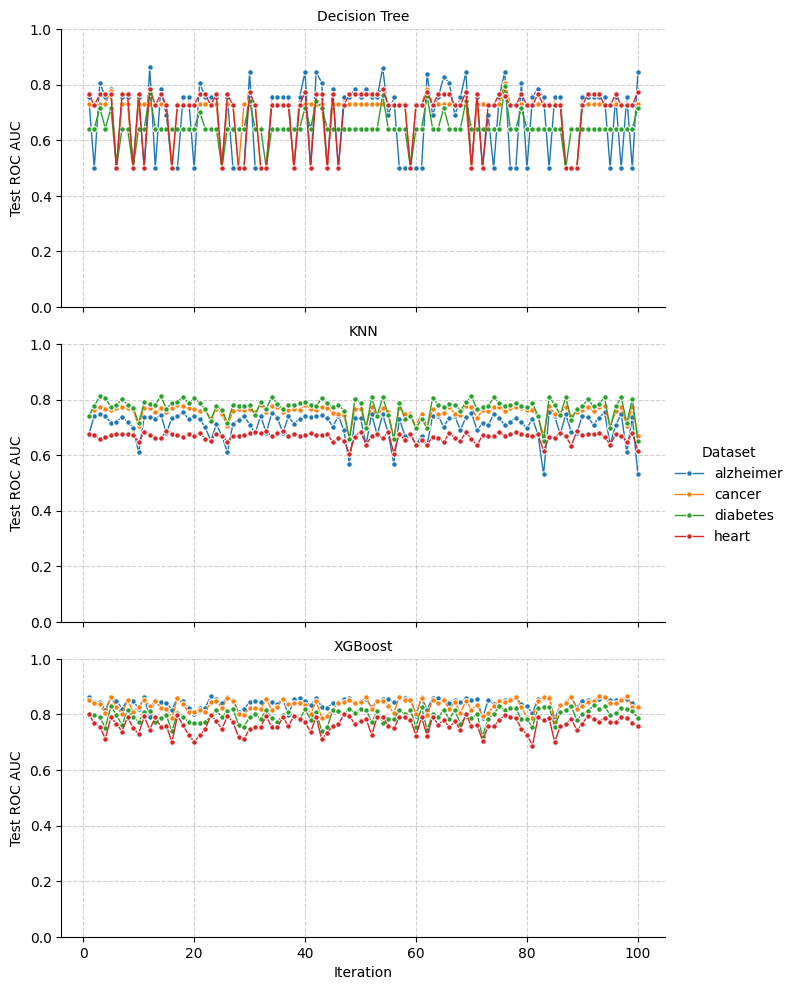

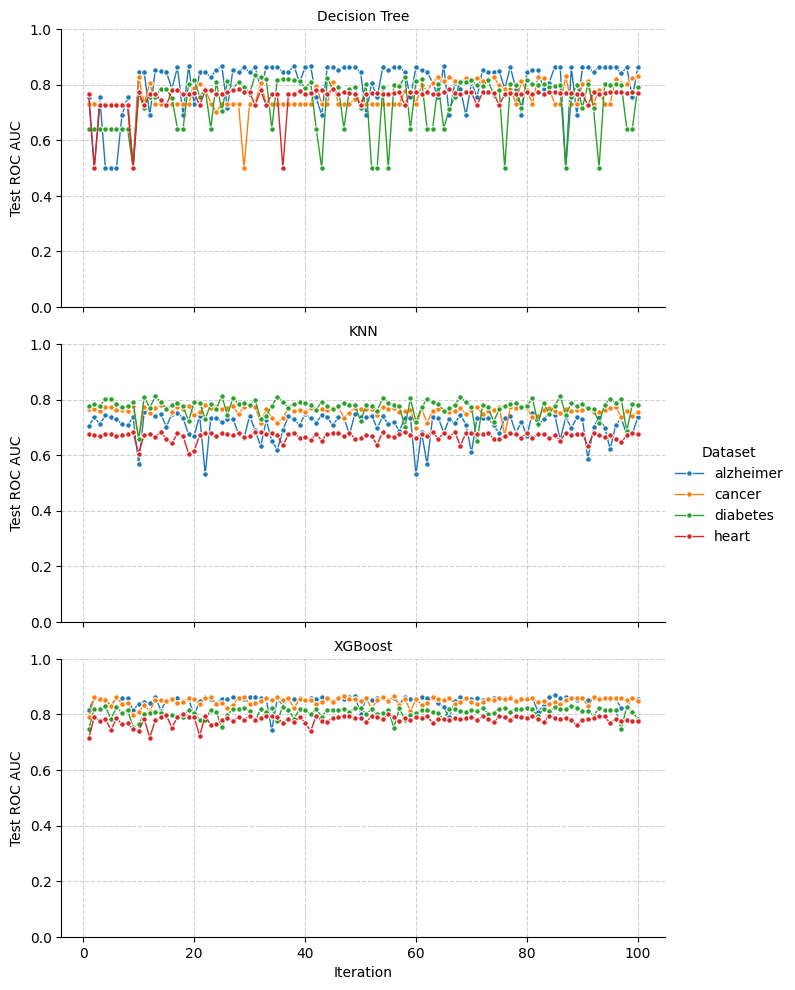

In [106]:
all_bayes = load_results("bayes")
all_random = load_results("uniform")

# Plots all points
plot_all_points(all_random, title_prefix="[Random Search] ")
plot_all_points(all_bayes, title_prefix="[Bayesian] ")

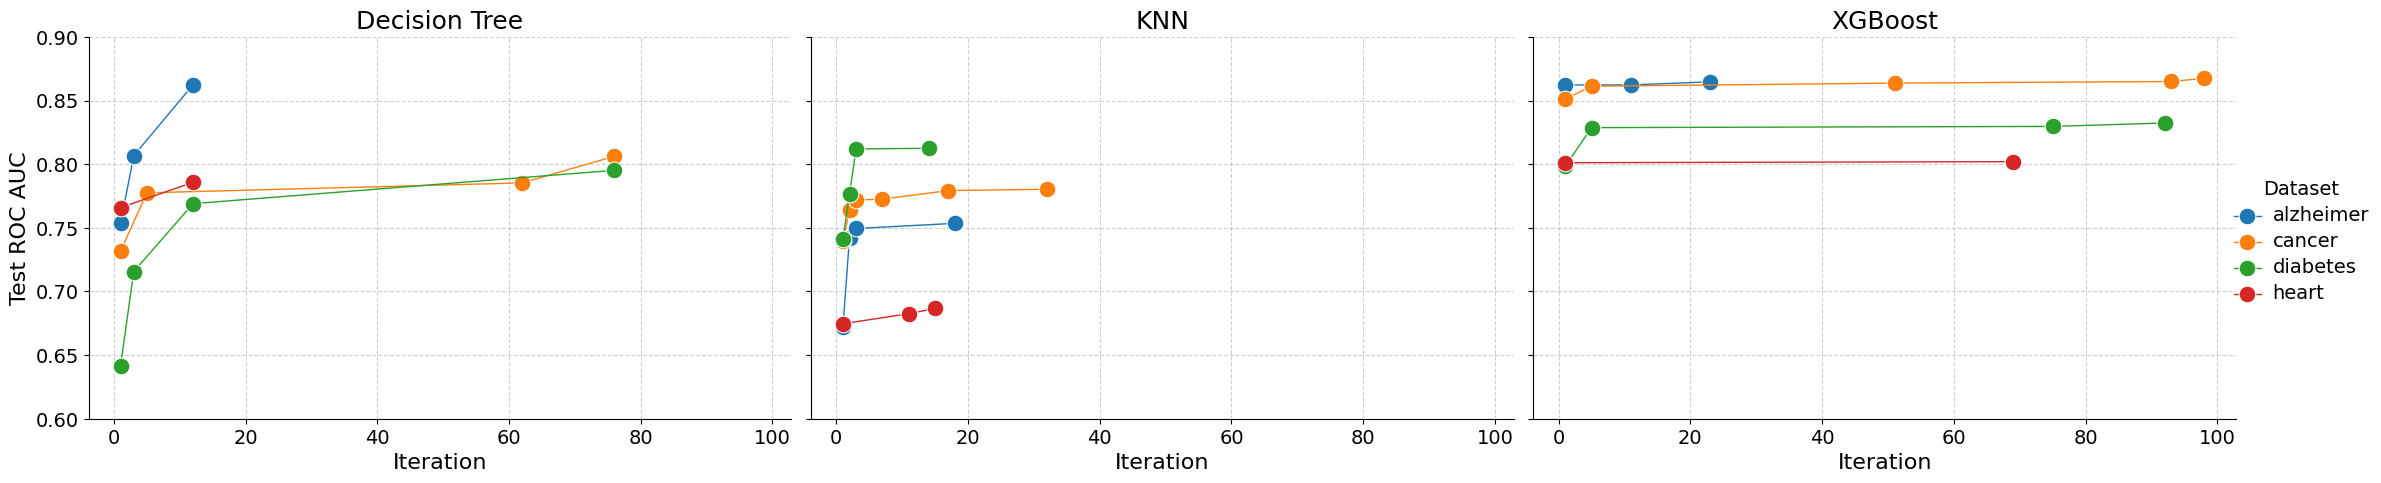

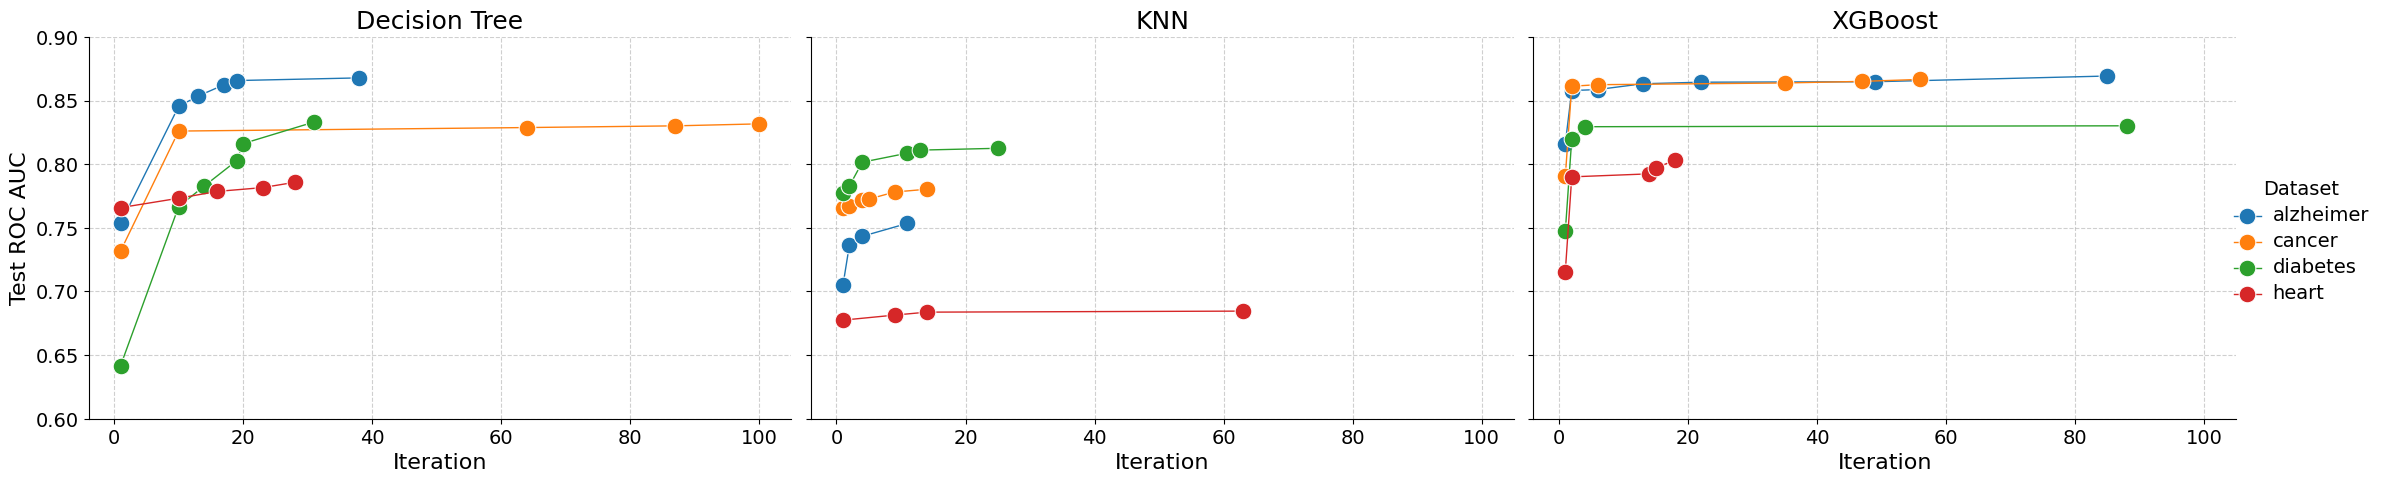

In [164]:
# Plots increasing points only
plot_auc_trends(all_random, title_prefix="[Random Search] ")
plot_auc_trends(all_bayes, title_prefix="[Bayesian] ")

In [108]:
# Boxplots for random distribution of diff_from_star to analyze model tunability
def plot_boxplot_diff_from_star(all_df, title_prefix=""):
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=all_df,
        x='model',            
        y='diff_from_star',  
        #palette='muted',    
        palette = {
            "XGBoost": "#75BF71",
            "Decision Tree": "#597DBF",
            "KNN": "#BF805C"
        },
        linewidth=1,
        fliersize=2
    )

    plt.ylabel("Difference from star")
    plt.xlabel("Model")
    # plt.title(f"{title_prefix}Difference from star per model")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    save_path = os.path.join("plots", "boxplot.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

C:\Users\Kasia\AppData\Local\Temp\ipykernel_26288\3120850412.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


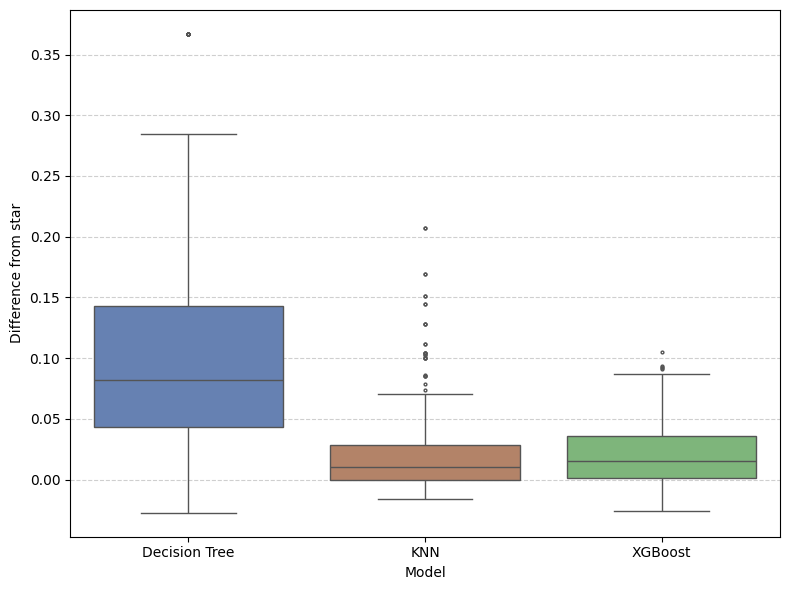

In [109]:
plot_boxplot_diff_from_star(all_random, title_prefix="[Random Search] ")

In [110]:
# Boxplots for random distribution of diff_from_star in all datasets to analyze model tunability

def plot_boxplot_diff_from_star_all_datasets(all_df, title_prefix=""):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=all_df,
        x='dataset',         
        y='diff_from_star', 
        hue='model',        
        #palette='muted',     
        palette = {
            "XGBoost": "#75BF71",
            "Decision Tree": "#597DBF",
            "KNN": "#BF805C"
        },
        linewidth=1,
        fliersize=2
    )

    plt.ylabel("Difference from star")
    plt.xlabel("Dataset")
    # plt.title(f"{title_prefix}Difference from star per dataset and model")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(title='Model')
    plt.tight_layout()

    save_path = os.path.join("plots", "boxplot_all_datasets.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

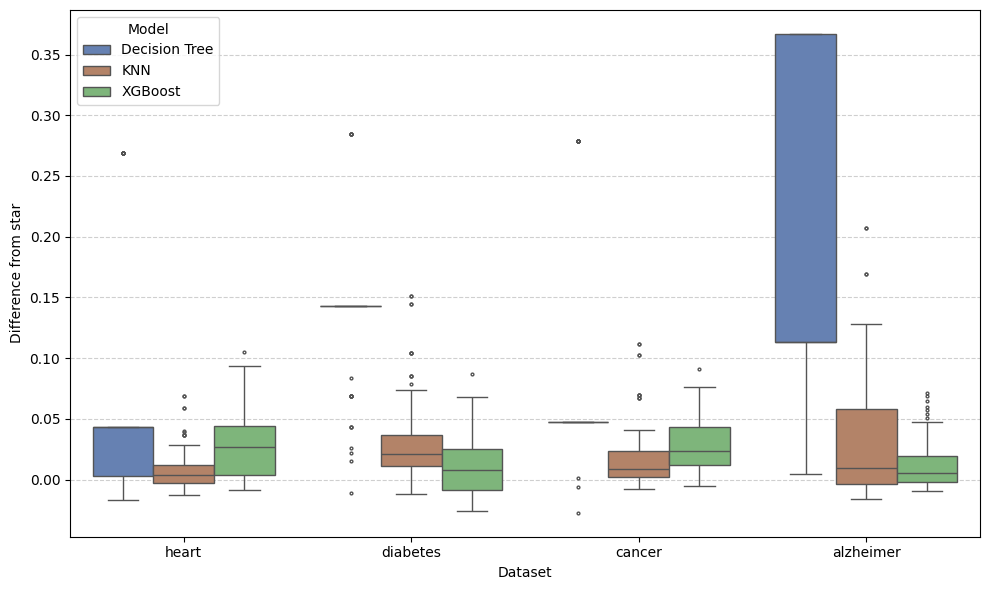

In [111]:
plot_boxplot_diff_from_star_all_datasets(all_random, title_prefix="[Random Search] ")

In [112]:
xgb_random_summary = pd.read_csv("Results/xgboost_uniform_summary.csv")
xgb_bayes_summary = pd.read_csv("Results/xgboost_bayes_summary.csv")
decisiontree_random_summary = pd.read_csv("Results/decisiontree_uniform_summary.csv")
decisiontree_bayes_summary = pd.read_csv("Results/decisiontree_bayes_summary.csv")
knn_random_summary = pd.read_csv("Results/knn_uniform_summary.csv")
knn_bayes_summary = pd.read_csv("Results/knn_bayes_summary.csv")

In [113]:
decisiontree_random_summary

,dataset,ccp_alpha,max_depth,min_samples_leaf,min_samples_split,test_roc_auc,star_test_roc_auc,default_test_roc_auc
0,alzheimer,0.006505,4.0,25.0,15.0,0.862409,0.866969,0.715910
1,cancer,0.000506,14.0,18.0,3.0,0.806296,0.778981,0.702465
2,diabetes,0.000506,14.0,18.0,3.0,0.795224,0.784597,0.704119
3,heart,0.006505,4.0,25.0,15.0,0.785811,0.768783,0.649975
4,STAR,0.003506,9.0,22.0,9.0,NaN,0.799833,NaN


In [114]:
# Function merges summary CSVs for Random Search and Bayesian Optimization results 
# and selects dataset, default, star, random and bayes test roc_auc columns.
def merge_summaries(random_df, bayes_df, model_name):
    merged = random_df.merge(bayes_df, on="dataset", suffixes=("_random", "_bayes"))
    merged = merged.rename(columns={
        "test_roc_auc_random": "random_test_roc_auc",
        "test_roc_auc_bayes": "bayes_test_roc_auc",
        "default_test_roc_auc_random": "default_test_roc_auc"
    })
    merged = merged[["dataset", "default_test_roc_auc", "star_test_roc_auc", "random_test_roc_auc", "bayes_test_roc_auc"]]
    merged["model"] = model_name
    return merged

In [115]:
decisiontree_sum = merge_summaries(decisiontree_random_summary, decisiontree_bayes_summary, "Decision Tree")
decisiontree_sum

,dataset,default_test_roc_auc,star_test_roc_auc,random_test_roc_auc,bayes_test_roc_auc,model
0,alzheimer,0.715910,0.866969,0.862409,0.867869,Decision Tree
1,cancer,0.702465,0.778981,0.806296,0.831729,Decision Tree
2,diabetes,0.704119,0.784597,0.795224,0.833194,Decision Tree
3,heart,0.649975,0.768783,0.785811,0.785811,Decision Tree


In [116]:
knn_sum = merge_summaries(knn_random_summary, knn_bayes_summary, "KNN")
knn_sum

,dataset,default_test_roc_auc,star_test_roc_auc,random_test_roc_auc,bayes_test_roc_auc,model
0,alzheimer,0.676913,0.737553,0.753539,0.753539,KNN
1,cancer,0.735195,0.772560,0.780356,0.780356,KNN
2,diabetes,0.712776,0.800597,0.812537,0.812537,KNN
3,heart,0.669854,0.674140,0.686630,0.684574,KNN


In [117]:
xgb_sum = merge_summaries(xgb_random_summary, xgb_bayes_summary, "XGBoost")
xgb_sum

,dataset,default_test_roc_auc,star_test_roc_auc,random_test_roc_auc,bayes_test_roc_auc,model
0,alzheimer,0.848140,0.855354,0.864761,0.869328,XGBoost
1,cancer,0.826089,0.862524,0.867462,0.866654,XGBoost
2,diabetes,0.794030,0.806866,0.832418,0.830209,XGBoost
3,heart,0.768240,0.793336,0.802025,0.803324,XGBoost


### Comparison of different dataset size subsets


In [118]:
# Reading data
path = "Results/"

models = ["xgboost", "decisiontree", "knn"]
methods = ["uniform", "bayes"]
sizes = [25, 50, 75, 100]

rows = []

for model in models:
    for method in methods:
        for size in sizes:
            if size == 100:
                filename = f"{model}_{method}_summary.csv"
            else:
                filename = f"{model}_{method}_summary_{size}.csv"
            filepath = os.path.join(path, filename)
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                df = df[df["dataset"] != "STAR"]
                df = df[["dataset", "test_roc_auc"]].copy()
                df["model"] = model
                df["method"] = method
                df["size"] = size
                rows.append(df)
            else:
                print(f"File not found: {filename}")

combined = pd.concat(rows, ignore_index=True)

combined["model"] = combined["model"].replace({
    "decisiontree": "Decision Tree",
    "knn": "KNN",
    "xgboost": "XGBoost"
})

print(combined)

      dataset  test_roc_auc    model   method  size
0   alzheimer      0.849592  XGBoost  uniform    25
1      cancer      0.851206  XGBoost  uniform    25
2    diabetes      0.810328  XGBoost  uniform    25
3       heart      0.788643  XGBoost  uniform    25
4   alzheimer      0.863642  XGBoost  uniform    50
..        ...           ...      ...      ...   ...
91      heart      0.687386      KNN    bayes    75
92  alzheimer      0.753539      KNN    bayes   100
93     cancer      0.780356      KNN    bayes   100
94   diabetes      0.812537      KNN    bayes   100
95      heart      0.684574      KNN    bayes   100

[96 rows x 5 columns]


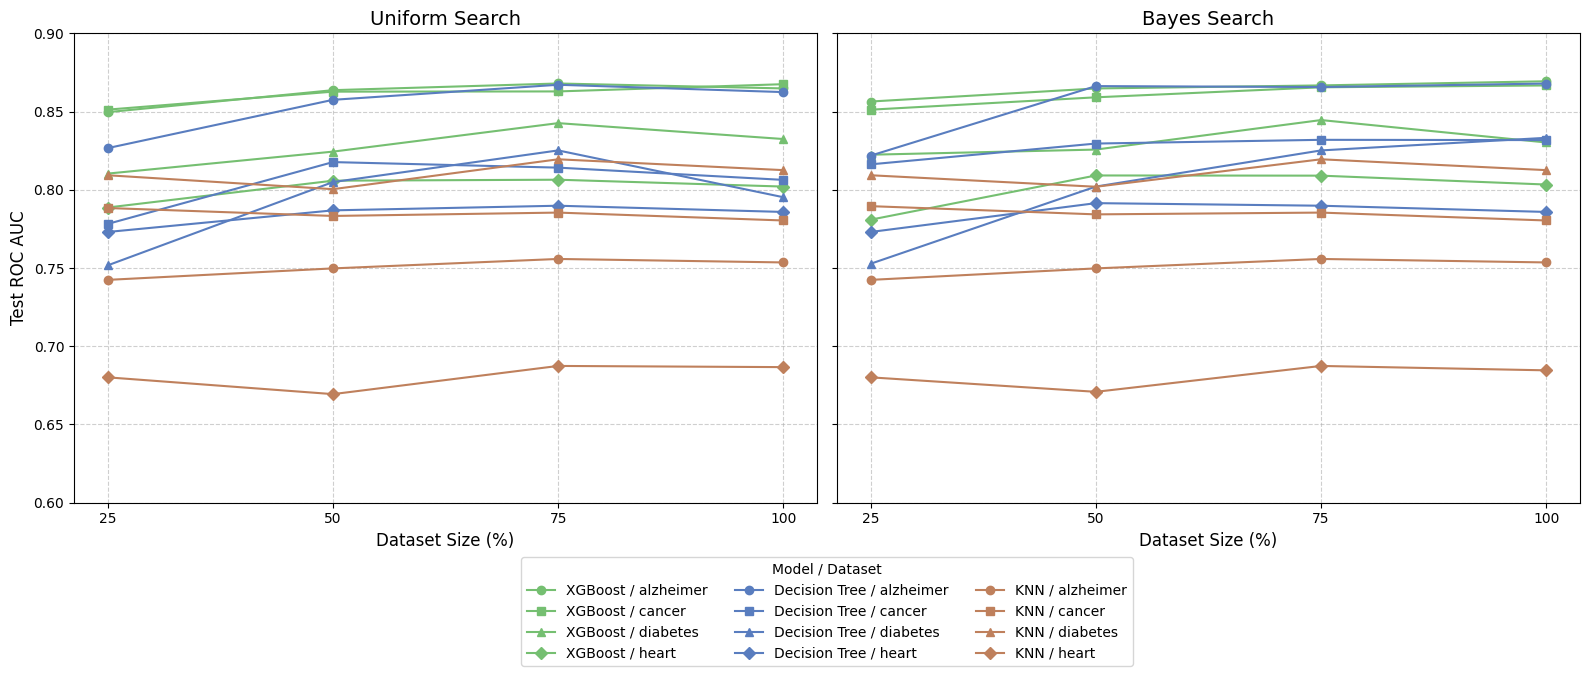

In [119]:
methods = combined['method'].unique()
models = combined['model'].unique()
datasets = combined['dataset'].unique()

colors = {
            "XGBoost": "#75BF71",
            "Decision Tree": "#597DBF",
            "KNN": "#BF805C"
        }
markers = ['o', 's', '^', 'D', 'x'] 

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, method in zip(axes, methods):
    for i, model in enumerate(models):
        for j, dataset in enumerate(datasets):
            subset = combined[(combined['method'] == method) &
                              (combined['model'] == model) &
                              (combined['dataset'] == dataset)]
            subset = subset.sort_values('size')
            ax.plot(
                subset['size'],
                subset['test_roc_auc'],
                color=colors.get(model, 'gray'),
                marker=markers[j % len(markers)],
                linestyle='-',
                label=f"{model} / {dataset}"
            )
    ax.set_title(f"{method.capitalize()} Search", fontsize=14)
    ax.set_xlabel("Dataset Size (%)", fontsize=12)
    ax.set_xticks([25, 50, 75, 100])
    ax.set_ylim(0, 1)
    axes[0].set_ylim(0.6, 0.9)
    axes[1].set_ylim(0.6, 0.9)
    ax.grid(True, linestyle='--', alpha=0.6)
    

axes[0].set_ylabel("Test ROC AUC", fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',       # umieszcza na dole figury
    bbox_to_anchor=(0.52, -0.18),  # przesunięcie w dół
    ncol=3,                   # liczba kolumn w legendzie
    fontsize=10,
    title="Model / Dataset"
)
#plt.suptitle("Test ROC AUC vs Dataset Size for Random vs Bayesian Search", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

save_path = os.path.join("plots", "subsets.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
                                
plt.show()


In [120]:
def load_results_size(result_type, results_dir="Results", sizes=[25, 50, 75, 100]):
    all_rows = []

    models = ["decisiontree", "knn", "xgboost"]
    for model in models:
        for size in sizes:
            if size == 100:
                filename = f"{model}_{result_type}.csv"
            else:
                filename = f"{model}_{result_type}_{size}.csv"
            
            filepath = os.path.join(results_dir, filename)
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                df["model"] = model
                df["size"] = size
                df["iteration"] = df.groupby("dataset").cumcount() + 1
                all_rows.append(df)
            else:
                print(f"File not found: {filename}")

    return pd.concat(all_rows, ignore_index=True)

all_bayes_size = load_results_size("bayes")
all_random_size = load_results_size("uniform")

In [121]:
def count_increasing_iterations(df, min_diff=0.01):
    results = []

    for size in df['size'].unique():
        for model in df['model'].unique():
            subset_model_size = df[(df['model'] == model) & (df['size'] == size)]
            for dataset in subset_model_size['dataset'].unique():
                subset = subset_model_size[subset_model_size['dataset'] == dataset].sort_values('iteration')
                iterations = subset['iteration'].values
                scores = subset['test_roc_auc'].values

                inc_iterations, inc_scores = get_increasing_points(iterations, scores)

                # We only was a significant increase, here we chose 0.01
                filtered_iterations = [it for it, sc, prev in zip(
                    inc_iterations, inc_scores, [0]+inc_scores[:-1]) if sc - prev > min_diff]

                results.append({
                    'size': size,
                    'model': model,
                    'dataset': dataset,
                    'num_increasing_iter': len(filtered_iterations), # number of iterations in which our score improved
                    'max_num_increasing_iter': max(filtered_iterations) # number of the last iteration in which our model improved

                })

    return pd.DataFrame(results)

bayes_inc_iters = count_increasing_iterations(all_bayes_size)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print(bayes_inc_iters)

    size         model    dataset  num_increasing_iter  max_num_increasing_iter
0     25  decisiontree      heart                    1                        1
1     25  decisiontree   diabetes                    2                       16
2     25  decisiontree     cancer                    3                       82
3     25  decisiontree  alzheimer                    3                       15
4     25           knn      heart                    2                       58
5     25           knn   diabetes                    3                        4
6     25           knn     cancer                    2                        2
7     25           knn  alzheimer                    2                        4
8     25       xgboost      heart                    4                       15
9     25       xgboost   diabetes                    2                       96
10    25       xgboost     cancer                    2                        2
11    25       xgboost  alzheimer       

In [122]:
# Small summary of number of iterations needed by Bayesian Optimalization in each of the algorithm
summary = bayes_inc_iters.groupby(["model", "size"])["max_num_increasing_iter"].agg(['mean', 'std'])
print(summary)

                    mean        std
model        size                  
decisiontree 25    28.50  36.318040
             50    11.50   3.000000
             75    10.00   0.000000
             100   13.00  12.727922
knn          25    17.00  27.349589
             50     2.25   1.258306
             75    10.25   9.945686
             100    4.25   4.716991
xgboost      25    29.00  45.055521
             50     2.25   0.500000
             75     2.00   0.000000
             100    2.00   0.000000


In [123]:
# Compute ratios of smaller dataset sizes to the full dataset for comparison
pivot = combined.pivot_table(
    index=["model", "method", "dataset"],
    columns="size",
    values="test_roc_auc"
).reset_index()

pivot.columns.name = None  
pivot = pivot.rename(columns={25: "test_25", 50: "test_50", 75: "test_75", 100: "test_100"})

pivot["ratio_25_100"] = pivot["test_25"] / pivot["test_100"]
pivot["ratio_50_100"] = pivot["test_50"] / pivot["test_100"]
pivot["ratio_75_100"] = pivot["test_75"] / pivot["test_100"]

print(pivot)

            model   method    dataset   test_25   test_50   test_75  test_100  ratio_25_100  ratio_50_100  ratio_75_100
0   Decision Tree    bayes  alzheimer  0.821809  0.866243  0.865638  0.867869      0.946927      0.998127      0.997430
1   Decision Tree    bayes     cancer  0.816231  0.829523  0.831904  0.831729      0.981366      0.997347      1.000211
2   Decision Tree    bayes   diabetes  0.752716  0.802030  0.825134  0.833194      0.903411      0.962597      0.990327
3   Decision Tree    bayes      heart  0.773011  0.791436  0.789787  0.785811      0.983711      1.007157      1.005059
4   Decision Tree  uniform  alzheimer  0.826618  0.857471  0.867090  0.862409      0.958499      0.994274      1.005428
5   Decision Tree  uniform     cancer  0.778173  0.817675  0.814131  0.806296      0.965120      1.014113      1.009717
6   Decision Tree  uniform   diabetes  0.751701  0.804896  0.825134  0.795224      0.945270      1.012162      1.037613
7   Decision Tree  uniform      heart  0